# Tutorial: Plummer Model


In [1]:
%load_ext autoreload
%autoreload 2

## TL;DR

In [2]:
import jax
import jax.numpy as jnp
from jax._src.config import config
config.update("jax_enable_x64", True)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
# use my stylesheet
plt.style.use('/Users/juan/phd/matplotlib/jdefault.mplstyle') # this should be changed something in the repo

#sampling and inference
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

#need to get rid of
import numpy as np

# project
from dynamicAll import models,fit,data
from dynamicAll.fit import Fit

In [4]:
model_params = {
    'M' : 1e5,
    'a': 0.5
}
model = models.Plummer(**model_params)
samples= model.sample_w_conditional(N=10_000,save=False)

In [7]:
r = np.sqrt(samples[:,0]**2 + samples[:,1]**2 + samples[:,2]**2)
v = np.sqrt(samples[:,3]**2 + samples[:,4]**2 + samples[:,5]**2)

[Text(0.5, 0, 'v [km/s]')]

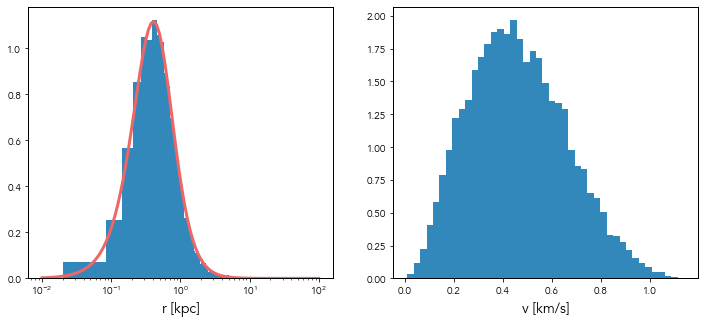

In [16]:
r_test = np.logspace(-2,2,100)
fig,ax = plt.subplots(ncols=2,figsize=(12,5))
ax[0].hist(r,bins='auto',density=True,label='samples')
ax[0].plot(r_test,model.probability(r_test),label='analytical pdf')
ax[0].set(
    xscale= 'log',
    xlabel= 'r [kpc]',
)
ax[1].hist(v,bins='auto',density=True,label='samples')
# ax[1].plot(v_test,model.probability_v(v_test),label='analytical pdf')
ax[1].set(
    xlabel= 'v [km/s]',
)

## Generating data from a Plummer sphere.

This one is quite simple and there are many examples of sampling from a plummer sphere, but lets go over it anyways.

The plummer sphere is defined by the density profile
\begin{equation}
\rho(r) = \frac{3M}{4\pi a^3}\left(1 + \frac{r^2}{a^2}\right)^{-5/2}
\end{equation}

For various systems, we'll have to numerically calculate the distribution function via the Eddington formula, but we'll start with the Plummer sphere where you can derive it analytically.
(See B&T for a derivation)

The distribution function for a Plummer sphere is given by

\begin{equation}
f(E) =
\frac{24\sqrt{2}}{7\pi^3}
\frac{a^2}{G^5 M^4}(-E)^{7/2}
\end{equation}

Where M is the total mass of the system, and a is the Plummer radius, and $E=\Phi(r) + \frac{1}{2}v^2$ is the energy of a particle and goes from $\Phi(r = 0) = -\frac{GM}{a}$ to 0. 


For the purposes of making mock data of a plummer sphere it is useful to remember that the distribution function is the joint probabilty of finding a star in the phase-space volume $d^{3}\vec{x}d^{3}\vec{w}$ around the position $\vec{x}$ and velocity $\vec{w}$, and that the density is the marginal probability of finding a star in the volume $d^{3}\vec{x}$ around the position $\vec{x}$.

We can therefore write the conditional probability of finding a star in the volume $d^{3}\vec{v}$ around the velocity $\vec{v}$ given that it is at position $\vec{x}$ using Bayes' theorem as
\begin{equation}
P(\vec{v}|\vec{x}) = \frac{P(\vec{x},\vec{v})}{P(\vec{x})} = \frac{f(E)}{\rho(\vec{x})}
\end{equation}

However, none of this is particularly useful, until we start rewriting some stuff.
\begin{equation}
F(E) = f(\vec{x},\vec{v})
\end{equation}
but because everything is spherical and Isotropic we can instead write down 
\begin{equation}
f(r,v)\sim v^{2}r^{2}\left[-\left(\Phi(r)+\frac{1}{2}v^{2}\right)\right]^{7/2}
\end{equation}

and also
\begin{equation}
p(r) = 4\pi r^{2}\rho(r)
\end{equation}
(where $M\equiv 1$, so thats its $p(r)$ is normalized)
and then
\begin{equation}
P(v|r) = \frac{F(r,v)}{p(r)} \sim \frac{v^{2}r^{2}\left[-\left(\Phi(r)+\frac{1}{2}v^{2}\right)\right]^{7/2}}{r^{2}\left(1+\frac{r^{2}}{a^{2}}\right)^{5/2}}
\end{equation}
However, any coefficient terms depending on r wont really matter since we're going to normalize it so we can ignore them.
\begin{equation}
P(v|r)\sim v^{2}\left[-\left(\Phi(r)+\frac{1}{2}v^{2}\right)\right]^{7/2}
\end{equation}
In order to sample from this, it would be convenient if it was normalized.
Here what people tend to do is to make another change of variables.
We define $q\equiv \frac{v}{v_{\rm esc}}$ where $v_{\rm esc}$ is the escape velocity at $r$.
since q can only be between 0 and 1, we can easily normalize it by integrating over the range of q.

Ultimately we can write 
\begin{equation}
p(q|r) =\frac{512}{7\pi}q^2(1-q^2)^{7/2}
\end{equation}
which *should* be easy to sample from. We've deceptible seemed to have gotten rid of the dependance of r, but we recover that dependance when we transform back via $v(r) = q~v_{\rm esc}(r)$

We still have a choice of sampling scheme here since the cdf is not analytically invertible. We can either use rejection sampling, or numerically calculate the cdf and extrapolate to get the inverse cdf, both work fine, rejection sampling works well enough for relatively large N, but the latter method might be better for very large N